In [26]:
#Librerías de procesamiento y visualización
from pyspark.sql import SparkSession
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#Librerías de NLP
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#Librerías de clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from sklearn.decomposition import LatentDirichletAllocation

#Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Crear a SparkSession
spark = (SparkSession
    .builder
    .appName('modelo')
    .getOrCreate())

#Leer parquet y llevar a pandas para poder usar librerías de python que son más amigables visualmente en el procesamiento de datos
df = spark.read.parquet('../abstracts/df.parquet').toPandas()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/20 19:53:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Pre procesamiento de datos

In [16]:
#Signos de puntuación y stop words a remover
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

#Stop words por fuera de la lista de spacy
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

#Parsear los textos
parser =  spacy.load("en_core_web_sm", disable=["tagger", "ner"])
parser.max_length = 7000000


#Funcion de parceo y estandarización de textos
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [19]:
tqdm.pandas()
df['processed_text'] = df['Abstract'].progress_apply(spacy_tokenizer)

100%|██████████| 13286/13286 [08:15<00:00, 26.84it/s]


In [20]:
# Función de vectorización, se llevan los textos a una notación columnar
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X


text = df['processed_text'].values
max_features = 2**12

# Se vectorizan los textos y se guarda en una nueva variable para el tratamiento de clustering
X = vectorize(text, max_features)

## Clustering (PCA & K-MEANS)

In [23]:
#PCA para reducir la complejidad dimensional y filtrará el ruido conservando el 95% de la varianza
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(13286, 2750)

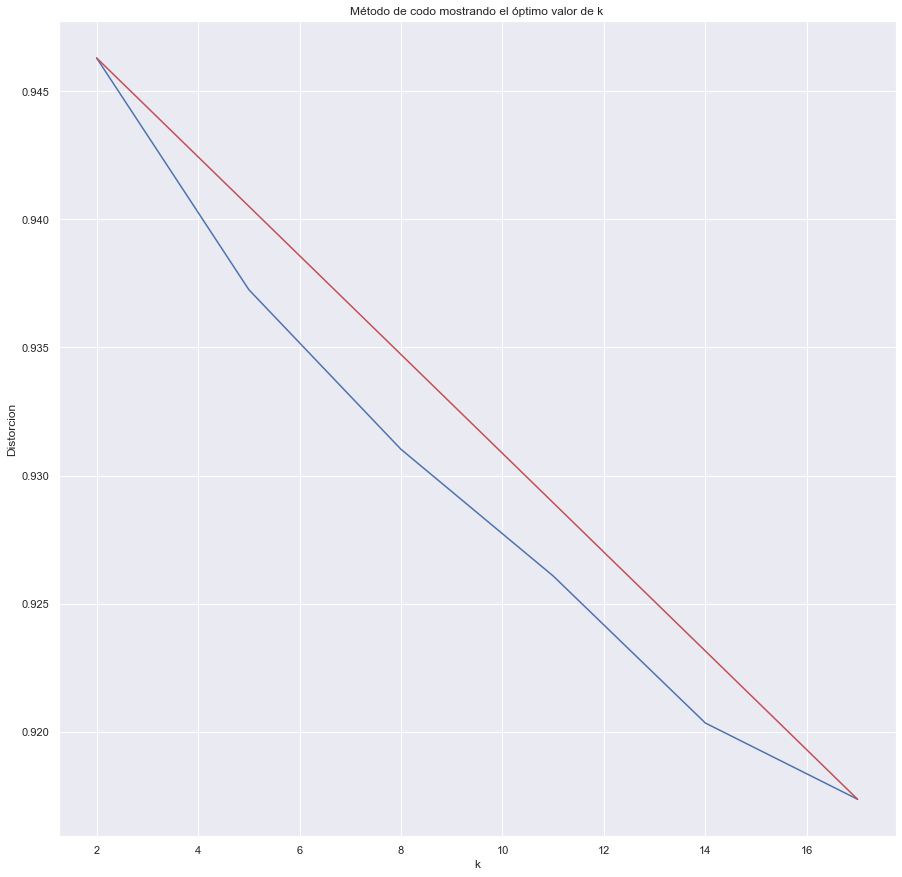

In [47]:
# Probar k means con diferentes valores de K para encontrar el número de clusters
distortions = []
K = range(2, 20, 3)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

%matplotlib inline
plt.figure(figsize=(15,15))
# Visualizar los valores de k en el método de codo
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distorcion')
plt.title('Método de codo mostrando el óptimo valor de k')
plt.savefig("Elbow kmenas.png")
plt.show()

In [28]:
#Se corre el k means con 14 clusters identificados por el gráfico de codo
k = 14
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

## Reducción dimensional con t-SNE

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 13286 samples in 0.027s...
[t-SNE] Computed neighbors for 13286 samples in 7.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13286
[t-SNE] Computed conditional probabilities for sample 2000 / 13286
[t-SNE] Computed conditional probabilities for sample 3000 / 13286
[t-SNE] Computed conditional probabilities for sample 4000 / 13286
[t-SNE] Computed conditional probabilities for sample 5000 / 13286
[t-SNE] Computed conditional probabilities for sample 6000 / 13286
[t-SNE] Computed conditional probabilities for sample 7000 / 13286
[t-SNE] Computed conditional probabilities for sample 8000 / 13286
[t-SNE] Computed conditional probabilities for sample 9000 / 13286
[t-SNE] Computed conditional probabilities for sample 10000 / 13286
[t-SNE] Computed conditional probabilities for sample 11000 / 13286
[t-SNE] Computed conditional probabilities for sample 12000 / 13286
[t-SNE] Computed conditional probabilities for sa

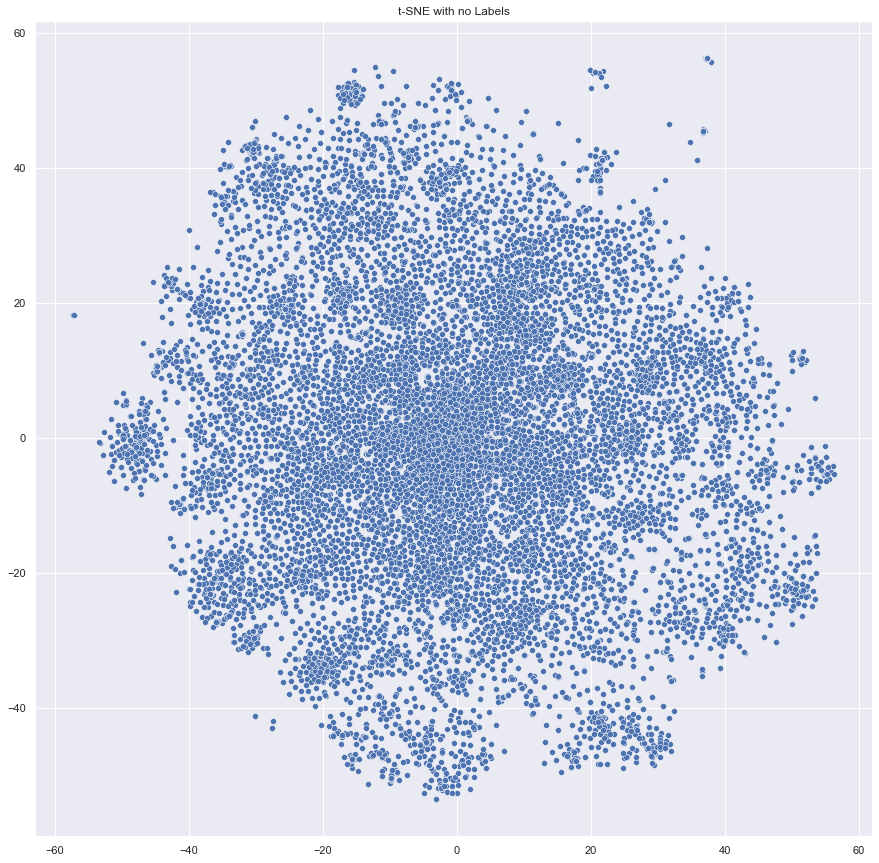

In [29]:
#Se reduce dimensionalidad a 2 para poder visualizar los clusters
tsne = TSNE(verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(X.toarray())

# sns configuración de tamaño
sns.set(rc={'figure.figsize':(15,15)})

# colores
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("Image0_tsne_model.png")
plt.show()

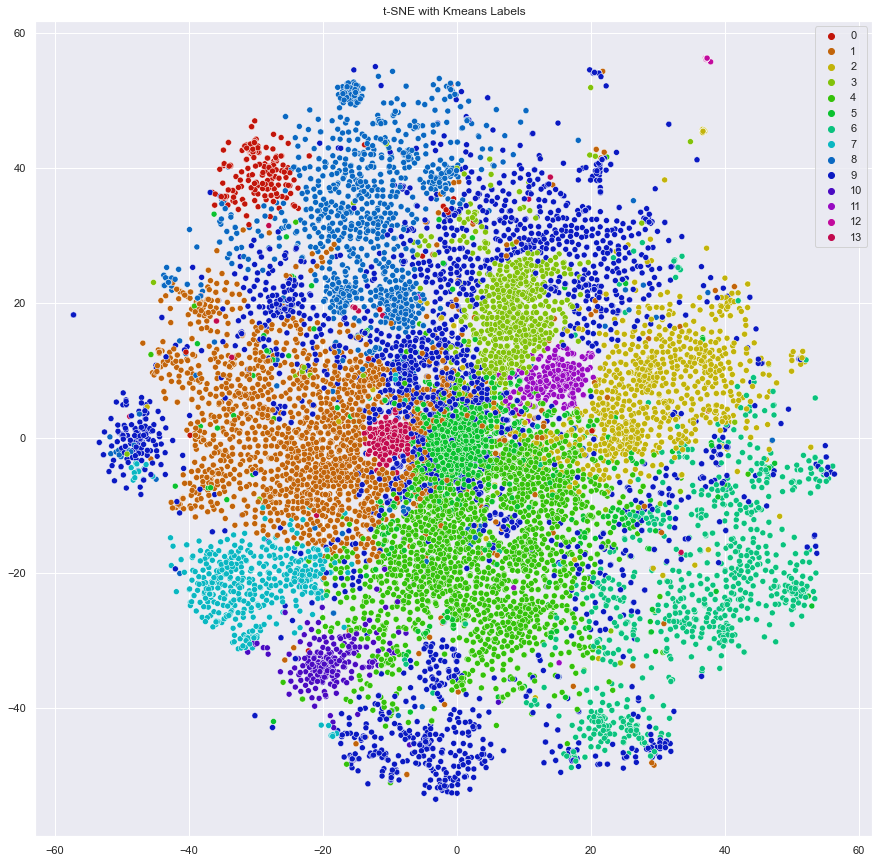

In [41]:
#Se vuelve a visualizar el kmeans pero ahora con los clusters
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns configuración de tamaño
sns.set(rc={'figure.figsize':(15,15)})

# colores
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("Image1_tsne_cluster.png")
plt.show()

## Topic Modeling on Each Cluster

> Hasta este punto se logró agrupar papers por su contenido semántico. Ahora es momento de interpretar cada cluster para saber que contenido tiene cada uno de ellos, para esto se corre un algoritmo de generación de tópicos llamado LatentDirichletAllocation. Este algoritmo es un modelo estadístico generativo que permite explicar conjuntos de palabras por un tema compartido.
número de temas por grupo

In [36]:
#Primero, crearemos k vectorizers, uno para cada uno de nuestros clusters
vectorizers = []
    
for ii in range(0, k):
    # Creando los vectorizers
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

#Vectorizamos cada uno de los clusters
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [52]:
#Se emplea Latent Dirichlet Allocation (LDA) para el modelamiento de tópicos
topics_per_cluster = 10
k = 14
lda_models = []

#Primero, crearemos k modelos, uno para cada uno de nuestros clusters
for ii in range(0, k):
    # Latent Dirichlet Allocation
    lda = LatentDirichletAllocation(n_components=topics_per_cluster, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)

#Se corren los modelos para cada cluster
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13


In [53]:
#Extrae las palabras clave de cada grupo

#Funciones para imprimir palabras clave para cada tópico
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values


#Agregar la lista de palabras clave para cada clúster
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13


In [54]:
#Ver tópicos por cluster
for i,cluster in enumerate(all_keywords):
    print('Cluster',i,'\n',np.array(cluster))

Cluster 0 
 ['students' 'teacher' 'high' 'mathematics' 'development' 'school'
 'science' 'computer' 'computing' 'energy' 'children' 'modeling' 'latinx'
 'early' 'learning' 'electronic' 'grade' 'stem' 'rural' 'university'
 'service' 'education']
Cluster 1 
 ['research' 'algorithms' 'methods' 'data' 'science' 'wireless' 'systems'
 'power' 'deep' 'learning' 'devices' 'spectrum' 'human' 'analysis'
 'control' 'software' 'privacy' 'cyber' 'radio' 'reinforcement' 'code'
 'verification' 'developers']
Cluster 2 
 ['species' 'plant' 'project' 'data' 'interactions' 'evolution' 'plants'
 'coral' 'forest' 'tree' 'food' 'fellowship' 'nitrogen' 'reef' 'reefs'
 'beetles' 'signals' 'beetle' 'care' 'hunting' 'parental' 'mosquito']
Cluster 3 
 ['public' 'social' 'research' 'models' 'science' 'model' 'work' 'data'
 'rapid' 'phase' 'spread' 'health' 'supply' 'food' 'attitudes'
 'households' 'pandemic' 'behaviors' 'urban' 'population' 'air' 'location'
 'mobile' 'privacy']
Cluster 4 
 ['properties' 'cell' 'c

In [60]:
#Clasificación de clusters según sus tópicos

top = {
    0: '0: Education',
    1: '1: Data Science',
    2: '2: Biology',
    3: '3: Social research',
    4: '4: Microbiology',
    5: '5: Research programs',
    6: '6: Climate change',
    7: '7: Mathematics',
    8: '8: Engineering research',
    9: '9: Physics',
    10: '10: Technology',
    11: '11: Coronavirus',
    12: '12: Other',
    13: '13: Robotics'
}

y_new = [top.get(item,item)  for item in y_pred]

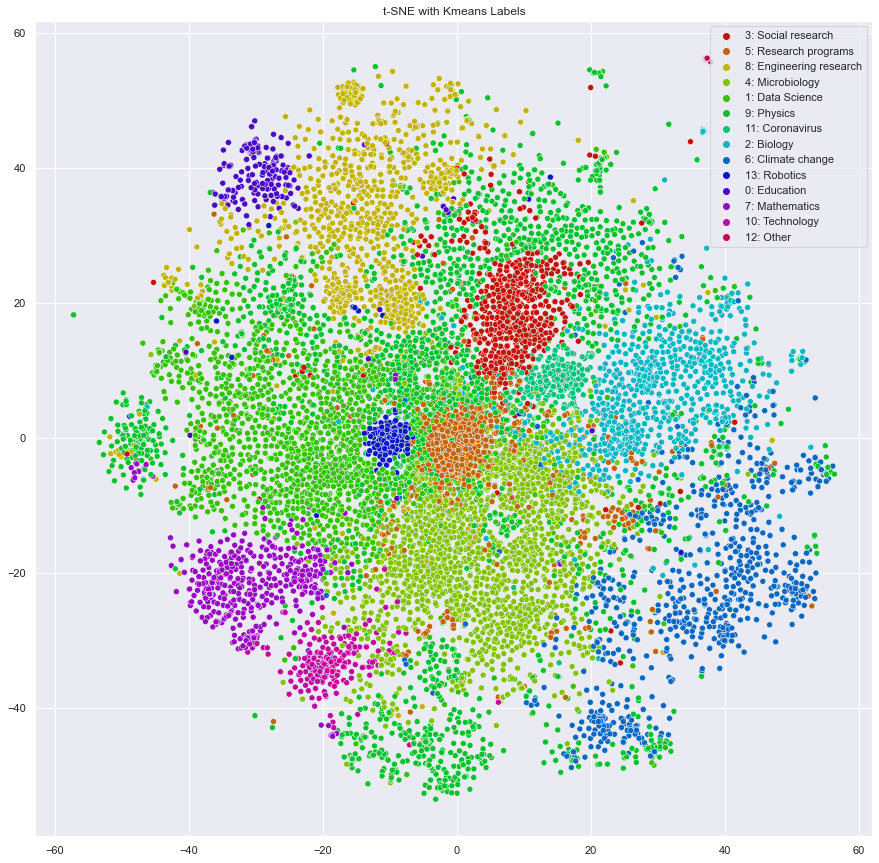

In [61]:
#Se visualiza nuevamente el kmeans en 2 dimensiones con sus respectivos clusters
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns configuración de tamaño
sns.set(rc={'figure.figsize':(15,15)})

# colores
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_new, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("Image2_tsne_LDA_with_kmeans_cluster.png")
plt.show()